In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consuption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
for gpu in gpus:
    print(gpu)

In [18]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')  # the same

In [19]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [20]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

## Collect positive and anchor classes

In [21]:
# Import uuid library to generate unique image names
import uuid

In [22]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\37986466-ae71-11ee-a253-14f6d8ef57d0.jpg'

In [53]:
OXFF = 0xFF

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame =  frame[120:120+250,200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & OXFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefull
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [8]:
frame.shape

(250, 250, 3)

## Load and preprocess images

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+"\*.jpg").take(300)
positive = tf.data.Dataset.list_files(POS_PATH+"\*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+"\*.jpg").take(300)

NameError: name 'ANC_PATH' is not defined

In [24]:
dir_test = anchor.as_numpy_iterator()

NameError: name 'anchor' is not defined

In [ ]:
dir_test.next()

In [31]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0  # help to effectively help optimize model and help gradient descent
    return img

In [32]:
img = preprocess('data\\anchor\\0d5820e7-ad63-11ee-8d11-14f6d8ef57d0.jpg')

In [33]:
img.numpy().min()

0.024754902

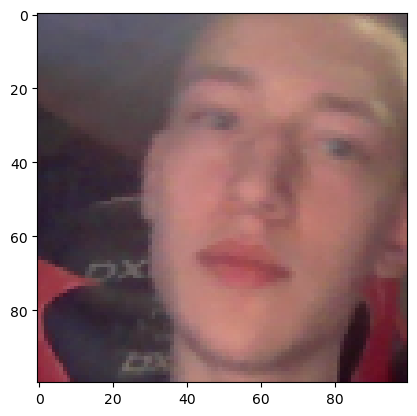

In [28]:
plt.imshow(img)

In [29]:
# (anchor, posigive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [30]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

NameError: name 'anchor' is not defined

In [16]:
samples = data.as_numpy_iterator()
example = samples.next()

NameError: name 'data' is not defined

In [26]:
example

(b'data\\anchor\\46612b0a-ad6c-11ee-a1fb-14f6d8ef57d0.jpg',
 b'data\\positive\\5d9cf66b-ad6c-11ee-9c07-14f6d8ef57d0.jpg',
 1.0)

In [27]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

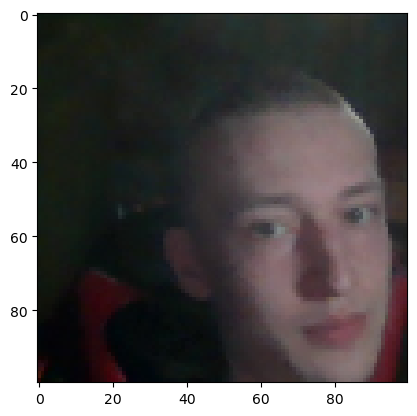

In [28]:
res = preprocess_twin(*example)
plt.imshow(res[1])

In [29]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [30]:
round(len(data)*.7)

227

In [31]:
# Training  partition
train_data = data.take(round(len(data)*.7))  # take first 70%
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [32]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()

In [33]:
len(train_sample[0])

16

In [44]:
# Testing partition
test_data = data.skip(round(len(data)*.7))  # skip first 70%
test_data = test_data.take(round(len(data)*.3)) # take last 30%
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Engineering

In [4]:
inp = Input(shape=(100, 100, 3))
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_1')>

In [5]:
c1 = Conv2D(64, (10, 10), activation='relu')(inp)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [6]:
mod = Model

In [34]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_shape')
    
    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
embedding = make_embedding()

In [36]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [37]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [38]:
l1 = L1Dist()
l1

## Make Siamese Model

In [39]:
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [40]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [41]:
siamese_layer = L1Dist()

In [42]:
distances = siamese_layer(inp_embedding, val_embedding)

In [43]:
classifier = Dense(1, activation='sigmoid')(distances)

In [44]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [45]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [46]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [47]:
siamese_model = make_siamese_model()

In [48]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [49]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)  # 0.0001

In [40]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [41]:
test_batch = train_data.as_numpy_iterator()

NameError: name 'train_data' is not defined

In [241]:
batch_1 = test_batch.next()
len(batch_1), len(batch_1[0])

(3, 16)

In [243]:
batch_1[2]

array([1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [244]:
X = batch_1[:2]

In [245]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [246]:
y = batch_1[2]
y

array([1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [258]:
@tf.function
def train_step(batch):
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return Loss
    return loss

In [262]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(EPOCHS+1):
        print("\n Epoch {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoits
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [263]:
EPOCHS = 50

In [264]:
train(train_data, EPOCHS)


 Epoch 0/50
15/15 [==============================] - 25s 2s/step

 Epoch 1/50
15/15 [==============================] - 25s 2s/step

 Epoch 2/50
15/15 [==============================] - 25s 2s/step

 Epoch 3/50
15/15 [==============================] - 25s 2s/step

 Epoch 4/50
15/15 [==============================] - 25s 2s/step

 Epoch 5/50
15/15 [==============================] - 25s 2s/step

 Epoch 6/50
15/15 [==============================] - 25s 2s/step

 Epoch 7/50
15/15 [==============================] - 27s 2s/step

 Epoch 8/50
15/15 [==============================] - 27s 2s/step

 Epoch 9/50
15/15 [==============================] - 26s 2s/step

 Epoch 10/50
15/15 [==============================] - 26s 2s/step

 Epoch 11/50
15/15 [==============================] - 27s 2s/step

 Epoch 12/50
15/15 [==============================] - 27s 2s/step

 Epoch 13/50
15/15 [==============================] - 27s 2s/step

 Epoch 14/50
15/15 [==============================] - 25s 2s/step

 Epo

## Evaluate Model

In [265]:
from tensorflow.keras.metrics import Precision, Recall

In [45]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [269]:
test_var = test_data.as_numpy_iterator().next()

In [298]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 679ms/step


array([[9.9999774e-01],
       [9.4803636e-06],
       [1.2348581e-04],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999976e-01],
       [6.0799135e-07],
       [1.0000000e+00],
       [5.6590767e-07],
       [2.6007854e-07],
       [9.9999154e-01],
       [8.3057450e-05],
       [9.9955267e-01],
       [2.8239310e-07],
       [1.0000000e+00],
       [9.9999422e-01]], dtype=float32)

In [300]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]

In [297]:
# Creating a metric object
m = Recall()

# Calculate the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

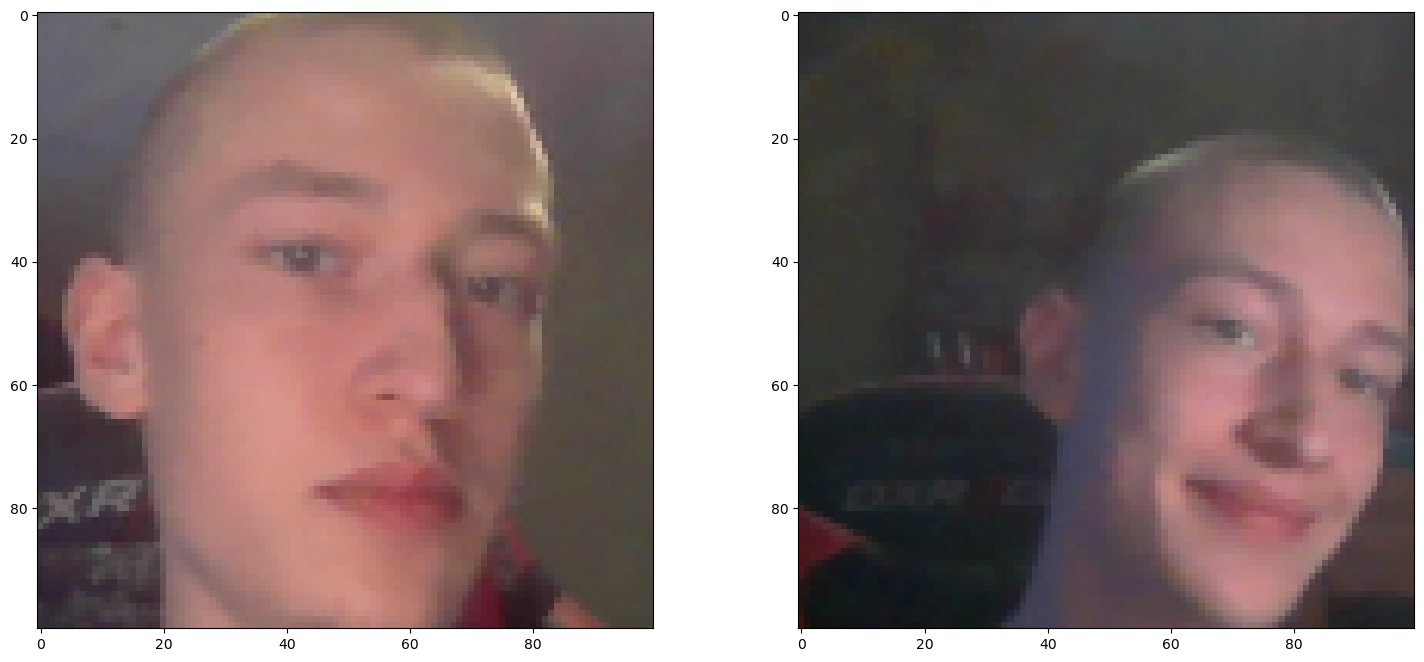

In [316]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[4])
plt.show()

### Save model

In [20]:
siamese_model.save('siamesemodel.keras')

In [50]:
# Reload model
model = tf.keras.models.load_model(
    'siamesemodel.keras',
    custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [23]:
model.predict([test_input, test_val])

NameError: name 'test_input' is not defined

## Veryfication Function

In [51]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [57]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 76ms/step
False


In [55]:
np.sum(np.squeeze(results) > 0.9)

0

In [56]:
results

[array([[0.4995661]], dtype=float32),
 array([[0.49955022]], dtype=float32),
 array([[0.4994666]], dtype=float32),
 array([[0.49953026]], dtype=float32),
 array([[0.49934638]], dtype=float32),
 array([[0.4992946]], dtype=float32),
 array([[0.49924895]], dtype=float32),
 array([[0.4992007]], dtype=float32),
 array([[0.49903932]], dtype=float32),
 array([[0.4990846]], dtype=float32),
 array([[0.49907768]], dtype=float32),
 array([[0.49922648]], dtype=float32),
 array([[0.4994233]], dtype=float32),
 array([[0.49948537]], dtype=float32),
 array([[0.4995776]], dtype=float32),
 array([[0.49960262]], dtype=float32),
 array([[0.49952596]], dtype=float32),
 array([[0.4994329]], dtype=float32),
 array([[0.49939245]], dtype=float32),
 array([[0.49942514]], dtype=float32),
 array([[0.49942058]], dtype=float32),
 array([[0.49942845]], dtype=float32),
 array([[0.4994282]], dtype=float32),
 array([[0.49939388]], dtype=float32),
 array([[0.49943903]], dtype=float32),
 array([[0.4994195]], dtype=float3